<font size= 4> **Wilson & Collins (2019) - Python Edition**

Created by Christina Maher (christina.maher@icahn.mssm.edu) based on Wilson & Collins (2019).

This notebook will run through the basics of **simulation**, **parameter recovery**, and **model recovery** for computational modeling of behavior using python ([based on Wilson & Collins (2019)'s "Ten simple rules for the computational modeling of behavioral data"](https://elifesciences.org/articles/49547)). Parameter fitting and model comparison will not be included in this tutorial. By the end of the notebook, we will have performed the following modeling steps:

**1. Simulation:** This involves running a particular model with defined parameter settings to generate fake behavioral data. For the purposes of this tutorial, we will simulate 2 of the models discussed in Wilson & Collins (2019): Noisy win-stay-lose-shift and Rescola Wagner. 

**2. Parameter recovery:** This involves checking whether the fitting procedure gives meaningful parameter values in the best case scenario, -that is, when fitting fake data where the ‘true’ parameter values are known (Wilson & Collins, 2019). This step is done to validate parameter fitting. 

**3. Model recovery:** This involves simulating data from all models (with a range of parameter values carefully selected as in the case of parameter recovery) and then fitting that data with all models to determine the extent to which fake data generated from model A is best fit by model A as opposed to model B (Wilson & Collins, 2019). This is done to validate model comparison.

In [ ]:
# Run this cell to install packages
! pip3 install [package_name]

In [1]:
# Load necessary packages 
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt # visualizing results 
from scipy.optimize import minimize # minimize function is used for parameter recovery 
import seaborn as sns # use this package for visualizing the confusion matrix in our model recovery step
pd.options.mode.chained_assignment = None  # default='warn'; change to avoid warnings

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Note, pd.append will be deprecated in a future version - see here for potential alternative in the event of issues.. https://stackoverflow.com/questions/70837397/good-alternative-to-pandas-append-method-now-that-it-is-being-deprecated

<font size= 4> **Simulation**

**Model #1: Noisy win-stay-lose-shift**

First, we will create our **noisy win-stay-lose-shift** model. This is a very simple model that adapts its behavior based on feedback. The model will repeat rewarded actions and move away from unrewarded actions. The noisy version of the model applies the win-stay-lose-shift policy with probability 1 - ε and will choose randomly with probability ε. For this model, ε is the *free parameter* which we perform parameter fitting and recovery on. Large values of epsilon result in more randomness. Small values of epsilon result in less randomness.  

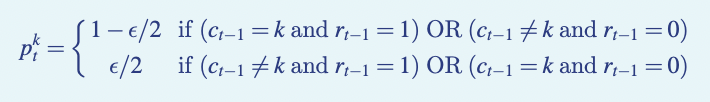

Let's create the noisy win-stay-lose-shift model as a function. The environment in this case will consist of a 2-armed bandit with average win probabilities = 0.20 (left bandit; aka choice 0) and 0.80 (right bandit, aka choice 1). 
By instantiating the model in this way, we can manipulate free parameter settings (epsilon) and simulate fake behavioral data of this model within a for-loop (i.e., for i in n_reps: (1) call function (2) save output).  

In [3]:
# Instantiate noisy win-stay-lose-shift model
def noisy_WSLS(T, mu, epsilon, rep):
    
  # T = number of trials per rep
  # mu = average reward of the two bandits
  # epsilon = determines probability of win-stay-lose-shift rule versus random choice 
  # rep = current rep (good to keep track of this for debugging/analysis/visualization purposes)
  
  # Initialize last reward/action as nan
    rLast = None
    aLast = None
  
  # initialize empty lists for storing choice and outcome
    a = []
    r = []
    rule = []
    previous_reward = []
  
    for t in range(T): # loop over the number of trials
      
    # compute choice probabilities depending on trial number
        if rLast == None: # First trial, when there is no reward history to inform bandit choice. We assume the probability of either bandit leading to reward is .50/.50.
           p = [0.50, 0.50]
        elif rLast == 1: # win stay (with probability 1-epsilon)
           p = epsilon/2 * np.array([1,1]) 
           p[aLast] = 1 - epsilon/2 
        else: # lose shift (with probability 1-epsilon)
           p = (1 - epsilon/2) * np.array([1,1])
           p[aLast] = epsilon/2 
    
    # make choice using computed choice probabilities
        eps = -1 * (np.finfo(float).eps)
        y = np.array(np.cumsum(p))
        x = np.array([eps,y[0],y[1]])
        xxx = np.where(x < np.random.random(1)[0])
        choice = np.argmax(x[xxx])
        a.append(choice) # save choice 
    
    # generate reward based on choice
        reward = int(np.random.random(1)[0] < mu[choice])
        r.append(reward) # save reward outcome
        
    # append "rule" variable for debugging/visualization purposes 
        if ((aLast == choice) and (rLast == 1)):
          rule.append("Stay")
        elif ((aLast != choice) & (rLast == 0)):
          rule.append("Shift")
        else:
          rule.append("Random")
        
        previous_reward.append(rLast)
    
        aLast = choice
        rLast = reward
  
  # save choices and reward in DF
    rep_num = [rep] * T 
    epsilon_value = [epsilon] * T
  
    DF = pd.DataFrame(list(zip(a, r, rep_num, epsilon_value, rule, previous_reward)),
               columns =['choice','reward','rep','epsilon','rule', 'previous_reward'])
    return DF   

**Simulation - Model #1: Noisy win-stay-lose-shift**

Let's simulate multiple repetitions (100 repetitions of 1000 trials each) with the same value of ε (ε = 0.10) for each repetition of the noisy win-stay-lose-shift model to generate fake behavioral data and visualize the result (as if it's a real dataset) to ensure that the model is performing as expected. 

In [27]:
# Simulate 100 repetitions of noisy win-stay-lose-shift model with the same value of epsilon for each repetition 
noisy_WSLS_DF = []
number_of_trials = 1000
number_of_reps = 100
current_rep = 1

for r in range(number_of_reps):
  epsilon_test = 0.10
  noisy_WSLS_rep_results = noisy_WSLS(T=number_of_trials, mu=[0.2, 0.8], epsilon = epsilon_test, rep = current_rep)
  noisy_WSLS_DF.append(noisy_WSLS_rep_results)
  current_rep = current_rep + 1
noisy_WSLS_DF = pd.concat(noisy_WSLS_DF)

Text(0, 0.5, 'p(Stay)')

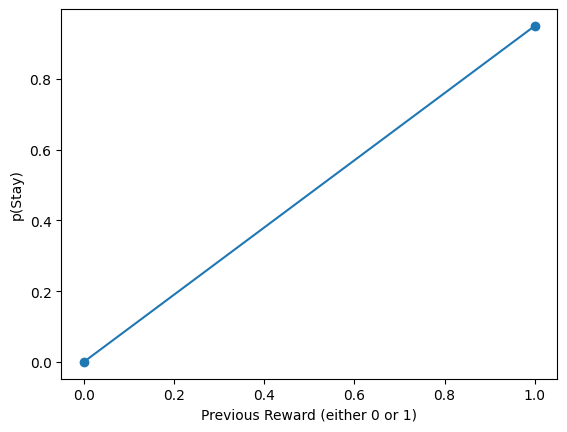

In [49]:
# Visualize results
p_stay = noisy_WSLS_DF.rule.eq('Stay').groupby([noisy_WSLS_DF.rep,noisy_WSLS_DF.previous_reward]).mean().mean(level=1)
Y = np.array([p_stay[0],p_stay[1]])
X = np.array([0,1])
plt.scatter(X, Y)
plt.plot(X, Y)

plt.xlabel("Previous Reward (either 0 or 1)")
plt.ylabel("p(Stay)")

Nice! With this visual we can see that our model is behaving as expected when we simulate. With ε = 0.10, agents demonstrate 0% chance of staying following a loss and 95% of staying following a win. 

Now let's simulate multiple repetitions (100 repetitions of 1000 trials each) with different values of ε for each reptition of the noisy win-stay-lose-shift model to see how toggling this parameter influences agents' behavior. 

In [50]:
# Simulate 100 repetitions of noisy win-stay-lose-shift model with different values of epsilon for each repetition 
noisy_WSLS_DF = []
number_of_trials = 1000
number_of_reps = 100
current_rep = 1

for r in range(number_of_reps):
    epsilon_test = np.random.random()
    noisy_WSLS_rep_results = noisy_WSLS(T=number_of_trials, mu=[0.2, 0.8], epsilon = epsilon_test, rep = current_rep)
    noisy_WSLS_DF.append(noisy_WSLS_rep_results)
    current_rep = current_rep + 1
noisy_WSLS_DF = pd.concat(noisy_WSLS_DF)

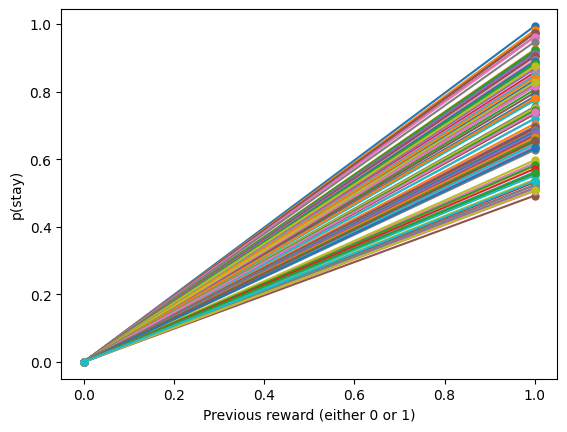

In [86]:
# Visualize results 
previous_loss = noisy_WSLS_DF[noisy_WSLS_DF["previous_reward"] == 0]
previous_win = noisy_WSLS_DF[noisy_WSLS_DF["previous_reward"] == 1]

p_stay_0 = previous_loss.rule.eq('Stay').groupby([previous_loss.epsilon]).mean().mean(level=0)
p_stay_1 = previous_win.rule.eq('Stay').groupby([previous_win.epsilon]).mean().mean(level=0)

#Creating a dictionary by passing Series objects as values
frame = {'p_stay_0': p_stay_0, 'p_stay_1': p_stay_1}
#Creating DataFrame by passing Dictionary
result = pd.DataFrame(frame)

groups = result.groupby('epsilon')

# Plot
fig, ax = plt.subplots()
for name, group in groups:
    x_val = np.array([0,1])
    y_val = np.array([group.p_stay_0,group.p_stay_1])
    ax.plot(x_val, y_val, marker='o', ms=5, label=name)

plt.xlabel("Previous reward (either 0 or 1)")
plt.ylabel("p(stay)")
plt.show()

Text(0, 0.5, 'p(Stay) - max simulated ε')

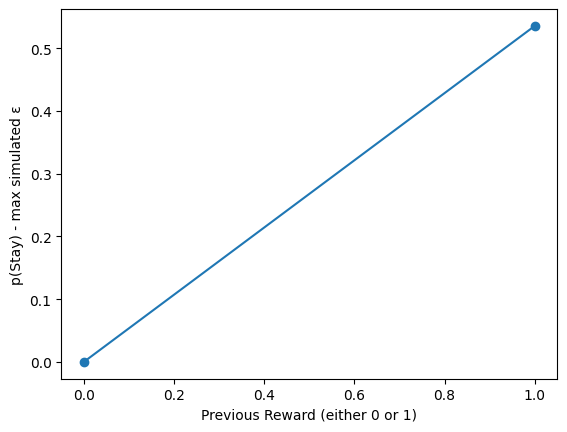

In [90]:
max_epsilon = noisy_WSLS_DF[noisy_WSLS_DF["epsilon"] == max(noisy_WSLS_DF["epsilon"])]
max_epsilon_stay = max_epsilon.rule.eq('Stay').groupby([max_epsilon.previous_reward]).mean().mean(level=0)

Y = np.array([max_epsilon_stay[0],max_epsilon_stay[1]])
X = np.array([0,1])
plt.scatter(X, Y)
plt.plot(X, Y)

plt.xlabel("Previous Reward (either 0 or 1)")
plt.ylabel("p(Stay) - max simulated ε")

Text(0, 0.5, 'p(Stay) - min simulated ε')

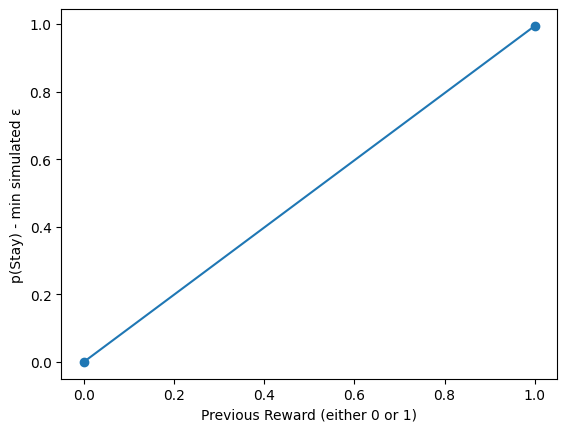

In [89]:
min_epsilon = noisy_WSLS_DF[noisy_WSLS_DF["epsilon"] == min(noisy_WSLS_DF["epsilon"])]
min_epsilon_stay = min_epsilon.rule.eq('Stay').groupby([min_epsilon.previous_reward]).mean().mean(level=0)

Y = np.array([min_epsilon_stay[0],min_epsilon_stay[1]])
X = np.array([0,1])
plt.scatter(X, Y)
plt.plot(X, Y)

plt.xlabel("Previous Reward (either 0 or 1)")
plt.ylabel("p(Stay) - min simulated ε")

The three plots below demonstrate the influence of ε on agents' behavior. The smaller the value of ε, the less random the behavior (aka increased probability of sticking to the win-stay-lose-shift rule) as compared to larger values of ε. This pattern is reflected when the probability of staying following loss vs. win is plotted for *all* repetitions. We can consider this free parameter (ε) to potentially reflect individual differences in real-world participants. Some participants may be more deterministic in following this heuristic while others are less deterministic and more random. This behavior would be reflected in the magnitude of their fitted ε!

**Model #2: Rescola Wagner**

Next, we will create our **Rescola Wagner** model. Here, agents first learn the expected value of each slot machine based on the history of previous outcomes and then use these values to make a decision about what to do next.

In this model, the value of option k, Q(k at t) is updated in response to reward r(t):

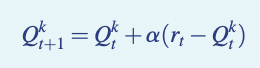

α in the above update equation is the learning rate - which takes a value between 0 and 1 (values closer to 0 result in a slower learning rate whereas values closer to 1 result in a quicker learning rate). This parameter captures the extent to which the prediction error (r(t) - Q(k at t)) updates the value of a stimulus. 

We assume that participants use the options’ values to guide their decisions, choosing the most valuable option most frequently, but occasionally making ‘mistakes’ (or exploring) by choosing a low-value option. One choice rule with these properties is known as the ‘softmax’ choice rule, which chooses option k with probability:

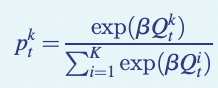

β is the ‘inverse temperature’ parameter which controls the level of stochasticity in the choice, ranging from β=0 for completely random responding and β=∞ for deterministically choosing the highest value option. For the Rescola Wagner model, α and β are *free parameters* which we perform parameter fitting and recovery on. 

Let's create the noisy win-stay-lose-shift model as a function. By instantiating the model in this way, we can manipulate free parameter settings and simulate fake behavioral data of this model within a for-loop (i.e., for i in n_reps: (1) call function (2) save output).

In [2]:
# Instantiate Rescola Wagner model
def rescola_wagner(T, mu, alpha, beta, rep):
    
    
  # T = number of trials per rep
  # mu = average reward of the two bandits
  # alpha = learning rate; takes a value between 0 and 1 and captures the extent to which the prediction error, (rt−Qkt)updates the value. 
  # beta = inverse temperature; controls the level of stochasticity in the choice, ranging from β=0 for completely random responding and β=∞for deterministically choosing the highest value option.
  # rep = current rep (good to keep track of this for debugging/analysis/visualization purposes)

  # initialize the values of selecting either of the two bandits as .50/.50 because the agent has yet to learn from experience regarding the most rewarding bandit. 
    q_dic = {'Q': [0.50,0.50]}
    q_df = pd.DataFrame(q_dic)
    Q = (q_df["Q"])
    
  # initialize empty lists for storing choice and outcome
    a = []
    r = []
    trial_num = []
    t_n = 1 # store trial number for analysis/visualization 
    
    for t in range(T): # run through number of trials in a given repetition 
        
        trial_num.append(t_n)
        
        # compute choice probabilities using softmax choice rule 
        p = np.exp(beta * Q) / sum(np.exp(beta * Q))
        
        
        # make choice according to choice probabilities 
        eps = -1 * (np.finfo(float).eps)
        y = np.array(np.cumsum(p))
        x = np.array([eps,y[0],y[1]])
        xxx = np.where(x < np.random.random(1)[0])
        choice = np.argmax(x[xxx])
        a.append(choice) # save choice 
        
        # generate reward based on choice 
        reward = int(np.random.random(1)[0] < mu[choice])
        r.append(reward) # save reward
        
        # update values 
        delta = reward - Q[choice]
        Q[choice] = Q[choice] + alpha * delta 
        
        t_n = t_n + 1
        
    # save choices and reward in DF
    rep_num = [rep] * T 
    alpha_value = [alpha] * T
    beta_value = [beta] * T
  
    DF = pd.DataFrame(list(zip(a, r, rep_num, alpha_value, beta_value, trial_num)),
               columns =['choice','reward','rep','alpha','beta','trial_num'])
    return DF


**Simulation - Model #2: Rescola Wagner**

Let's simulate multiple repetitions of the Rescola Wagner to generate fake behavioral data and visualize the result (as if it's a real dataset) to ensure that the model is performing as expected. 

We will set the means of each bandit at μ1=0.2 and μ2=0.8 and the number of trials at T=1000. We then simulated the actions of the model according to the above equations, with learning rate, α, and softmax temperature, β, set according to: 

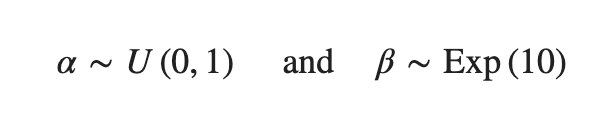

In [103]:
# Simulate 100 repetitions of Rescola Wagner model performing 1000 trials each and visualize performance
RW_DF = []
number_of_trials = 1000
number_of_reps = 100
current_rep = 1

for r in range(number_of_reps):
    alpha_test = np.random.random()
    beta_test = random.randint(1,100)
    RW_rep_results = rescola_wagner(T=number_of_trials, mu=[0.2, 0.8], alpha = alpha_test, beta = beta_test, rep = current_rep)
    RW_DF.append(RW_rep_results)
    current_rep = current_rep + 1
RW_DF = pd.concat(RW_DF)


Let's ensure the model is working correctly by plotting a learning curve.

Text(0, 0.5, 'Percent of agents that selected the most valuable bandit')

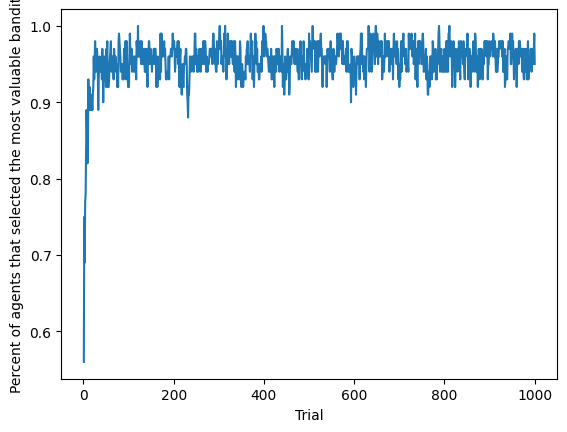

In [104]:
# Visualize results 

avg_correct_by_trial = RW_DF.choice.groupby([RW_DF.trial_num]).mean()

plt.plot(avg_correct_by_trial)
plt.xlabel("Trial")
plt.ylabel("Percent of agents that selected the most valuable bandit")

Nice! The learning curve demonstrates that agents are behaving as expected - they are learning from experience to select the most valuable bandit (i.e., the bandit with the highest probability of leading to reward). 

In [305]:
# Simulate 100 repetitions of Rescola Wagner model performing 1000 trials each and visualize performance
RW_DF = []
number_of_trials = 1000
number_of_reps = 10
current_rep = 1

beta_options = [1,2,5,10,20] # let's predefined the beta values we will try so that we can systematically test the interaction of our free parameters and the influence of this interaction on the agents' behavior
alpha_options = np.arange(0.02,1,0.02)

for a in range(len(alpha_options)):
    alpha_test = alpha_options[a]
    
    for b in range(len(beta_options)):
        # result of this loop is a dataframe with number_of_trials x number_of_reps x beta_options to produce a dataframe with 500,000 rows
        beta_test = beta_options[b]
    
        for r in range(number_of_reps):
            RW_rep_results = rescola_wagner(T=number_of_trials, mu=[0.2, 0.8], alpha = alpha_test, beta = beta_test, rep = current_rep)
            RW_DF.append(RW_rep_results)
            current_rep = current_rep + 1
        
RW_DF = pd.concat(RW_DF)

In [306]:
first_10_trials = RW_DF.groupby([RW_DF.rep]).nth[0,1,2,3,4,5,6,7,8,9]
last_10_trials = RW_DF.groupby([RW_DF.rep]).nth[990,991,992,993,994,995,996,997,998,999]

first_10_trials = first_10_trials.reset_index()
last_10_trials = last_10_trials.reset_index()

Text(0, 0.5, 'Percent correct - first 10 trials')

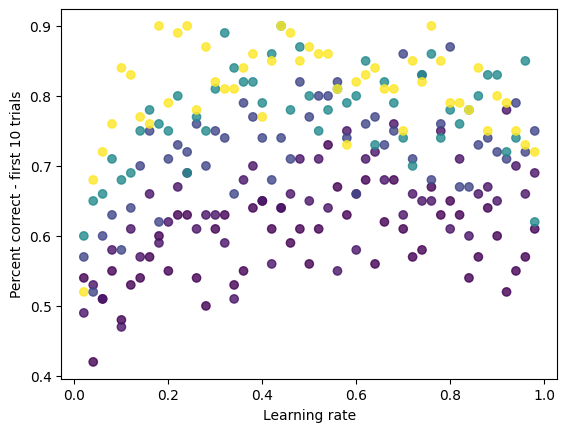

In [325]:
## First 10 trials
avg_correct_by_rep = first_10_trials.choice.groupby([first_10_trials.alpha,first_10_trials.beta]).mean()
avg_correct_by_rep = pd.DataFrame(avg_correct_by_rep)
avg_correct_by_rep = avg_correct_by_rep.reset_index()

plt.scatter(avg_correct_by_rep['alpha'], avg_correct_by_rep['choice'], marker = 'o', c = avg_correct_by_rep['beta'], alpha = 0.8)
plt.xlabel("Learning rate")
plt.ylabel("Percent correct - first 10 trials")

Text(0, 0.5, 'Percent correct - last 10 trials')

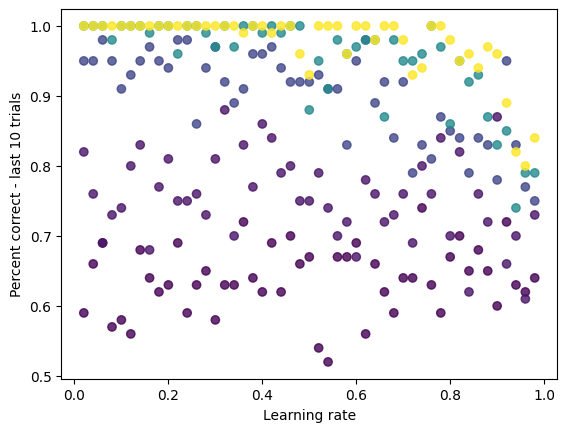

In [317]:
## Last 10 trials
avg_correct_by_rep = last_10_trials.choice.groupby([last_10_trials.alpha,last_10_trials.beta]).mean()
avg_correct_by_rep = pd.DataFrame(avg_correct_by_rep)
avg_correct_by_rep = avg_correct_by_rep.reset_index()

plt.scatter(avg_correct_by_rep['alpha'], avg_correct_by_rep['choice'], marker = 'o', c = avg_correct_by_rep['beta'], alpha = 0.8)
plt.xlabel("Learning rate")
plt.ylabel("Percent correct - last 10 trials")

*Note: dark - light color is lower to higher beta values.*

As we can see in the plots above, 10 repetitions per parameter setting (i.e., specific combination of alpha and beta values) influence two aspects of behavior: early performance (first 10 trials), and late performance (last 10 trials). The first graph shows that learning rate is positively correlated with early performance improvement only for low b values or for very low a values. For high b values, there is a U-shape relationship
between learning rate and early speed of learning. The right graph shows that with high b values, high learning rates negatively influence asymptotic behavior. Thus, we can conclude from visualizing the results in this way that both parameters interact to influence both thespeed of learning and asymptotic performance.

<font size= 4> **Parameter Recovery** 

    
<font size= 2> First, simulate fake data with known parameter values. Next, fit the model to these fake data to try to ‘recover’ the parameters. Finally, compare the recovered parameters to their true values. In a perfect world, the simulated and recovered parameters will be tightly correlated, with no bias.

**Parameter Recovery - Model #1: Noisy win-stay-lose-shift** 

Let's simulate multiple repetitions of the model with different free parameter values. Then, let's fit the model to this data using a maximum likelihood approach. To see whether parameter recovery is successful, we will plot the simulated and fitted parameter values for each reptitions. We know that parameter recovery was successful if there is a tight positive correlation between the simulated and fitted values.

In the *maximum likelihood approach* to model fitting, our goal is to find the parameter values of model m, 𝜽^MLEm, that maximize the likelihood of the data, d1:T, given the parameters, p(d1:T|𝜽m,m). Maximizing the likelihood is equivalent to maximizing the log of the likelihood OR minimizing the negative log of the likelihood (using the minimize function in the scipy.optimize library. 

In [35]:
# log likelihood function for noisy win-stay-lose-shift model
def negLL_noisyWSLS(params,rep):
    # a - a vector of length equal to the number of trials per rep containing choice history for a given repetition
    # r - a vector of length equal to the number of trials per rep containing reward history for a given repetition
    # params - list of k equal to the number of free parameters to be fitted
    # rep - rep number 
    
    a = rep["choice"]
    r = rep["reward"]
    
    epsilon = params[0]
    
    # Initialize last reward/action as nan
    rLast = None
    aLast = None
    
    T = len(a)
    
    # initialize empty list for storing choice probability 
    choiceProb = []
    
    trial_num = 0
    
    for t in range(T):
        # compute choice probabilities depending on trial number
        if rLast == None:
        # First trial, when there is no reward history to inform bandit choice. We assume the probability of either bandit leading to reward is .50/.50.
            p = [0.50, 0.50]
        elif rLast == 1: # win stay (with probability 1-epsilon)
            p = epsilon/2 * np.array([1,1]) 
            p[aLast] = 1 - epsilon/2 
        else: # lose shift (with probability 1-epsilon)
            p = (1 - epsilon/2) * np.array([1,1])
            p[aLast] = epsilon/2 
        
        c = a[trial_num]
        cp = p[c]
        choiceProb.append(cp)
        aLast = c
        rLast = r[trial_num]
        trial_num = trial_num + 1 
    
    # compute negative loglikelihood using choice probabilities (the negLL is the value we want to minimize to perform parameter recovery/fitting)
    NegLL = -sum(np.log(choiceProb))
    return(NegLL)

In [36]:
# fitting function for noisy win-stay-lose-shift model that minimizes the log likelihood function created above.
def fit_noisyWSLS(a, r, epsilon):
    # a - a vector of length equal to the number of trials per rep containing choice history for a given repetition
    # r - a vector of length equal to the number of trials per rep containing reward history for a given repetition
    # epsilon - the value of epsilon used for simulation (passed here for visualizing parameter recovery)
    
    starting_epsilon = np.random.random()
    
    x0 = [starting_epsilon]
    
    bnds = ((0,1),) # sequence of min, max pairs for free parameters
    
    rep_data = pd.concat([a,r],axis=1)
    
    optim_output = minimize(negLL_noisyWSLS, x0, args=(rep_data),method='L-BFGS-B',bounds=bnds)
    fitted_epsilon = optim_output.x[0]
    
    data = pd.DataFrame({'fitted_epsilon': [fitted_epsilon], 'simulated_epsilon':[epsilon]}) 
    return data

In [41]:
np.seterr(divide = 'ignore')  # otherwise you get a run warning about dividing by 0; can turn warning back on by setting this equal to 'warn'
# Perform parameter recovery over 100 repetitions of the model and visualize the results as a scatter plot.
parameter_recovery_df = []
number_of_trials = 1000
number_of_reps = 100
current_rep = 1

for r in range(number_of_reps):
    epsilon_test = np.random.random()
    noisy_WSLS_rep_results = noisy_WSLS(T=number_of_trials, mu=[0.2, 0.8], epsilon = epsilon_test, rep = current_rep)
    choice = noisy_WSLS_rep_results["choice"]
    reward = noisy_WSLS_rep_results["reward"]
    
    param_recovery = fit_noisyWSLS(a=choice, r=reward, epsilon= epsilon_test)
    parameter_recovery_df.append(param_recovery)
    
    current_rep = current_rep + 1

parameter_recovery_df = pd.concat(parameter_recovery_df)
print(parameter_recovery_df)

    fitted_epsilon  simulated_epsilon
0         0.738740           0.748691
0         0.895473           0.177570
0         0.596597           0.625150
0         0.980981           0.954241
0         0.099945           0.045727
..             ...                ...
0         0.940939           0.965309
0         0.574575           0.638816
0         0.892893           0.886584
0         0.810659           0.476207
0         0.601750           0.214764

[100 rows x 2 columns]


In [44]:
# Calculate correlation for parameter recovery 
parameter_recovery_df['simulated_epsilon'].corr(parameter_recovery_df['fitted_epsilon'])

0.7711728737258606

Text(0, 0.5, 'Fitted epsilon')

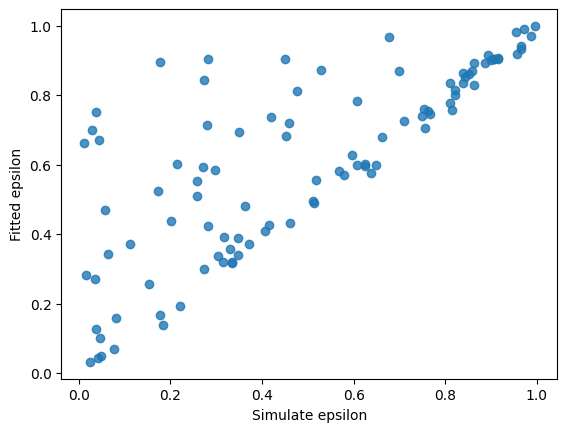

In [42]:
# Visualize parameter recovery!
plt.scatter(parameter_recovery_df['simulated_epsilon'], parameter_recovery_df['fitted_epsilon'], marker = 'o', alpha = 0.8)
plt.xlabel("Simulate epsilon")
plt.ylabel("Fitted epsilon")

**Parameter Recovery - Model #2: Rescola Wagner** 

Let's simulate multiple repetitions of the model with different free parameter values. Then, let's fit the model to this data using a maximum likelihood approach. To see whether parameter recovery is successful, we will plot the simulated and fitted parameter values for each reptitions. We know that parameter recovery was successful if there is a tight positive correlation between the simulated and fitted values.

In [99]:
# log likelihood function for Rescola Wagner model
def negLL_rescola_wagner(params,rep):
    # a - vector of length equal to the number of trials in a given repetition storing choice history
    # r - 0 vector of length equal to the number of trials in a given repetition storing reward history
    # params - list of length equal to the number of free parameters in the model to be optimized
    # rep - rep number 
    
    alpha = params[0]
    beta = params[1]
    
    a = rep["choice"]
    r = rep["reward"]
    
    q_dic = {'Q': [0.50,0.50]}
    q_df = pd.DataFrame(q_dic)
    Q = (q_df["Q"])
    
    T = len(a)
    
    # initialize empty list for storing choice probability
    choiceProb = []
    
    for t in range(T):
        # compute choice probabilities using softmax choice rule
        p = np.exp(beta * Q) / sum(np.exp(beta * Q))
        
        c = a[t]
        
        # compute choice probability for actual choice
        choiceProb.append(p[c])
        
        # update values
        delta = r[t] - Q[c]
        Q[c] = Q[c] + alpha * delta
        
    #  compute negative loglikelihood using choice probabilities (the negLL is the value we want to minimize to perform parameter recovery/fitting)
    NegLL = -sum(np.log(choiceProb))
    return(NegLL)

In [100]:
# fitting function for Rescola Wagner model that minimizes the log likelihood function created above.
def fit_rescola_wagner(a, r, alpha, beta):
    # a - a vector of length equal to the number of trials per rep containing choice history for a given repetition
    # r - a vector of length equal to the number of trials per rep containing reward history for a given repetition
    # alpha - the value of alpha used for simulation (passed here for visualizing parameter recovery)
    # beta - the value of beta used for simulation (passed here for visualizing parameter recovery)
    
    starting_alpha = np.random.random()
    starting_beta = random.randint(1,100)
    
    x0 = [starting_alpha,starting_beta]
    
    bnds = ((0, 1), (1, 100)) # sequence of min, max pairs for alpha and beta
    
    rep_data = pd.concat([a,r],axis=1) # pass these values as a data frame
    
    optim_output = minimize(negLL_rescola_wagner, x0, args=(rep_data),method='L-BFGS-B',bounds=bnds)
    fitted_alpha = optim_output.x[0]
    fitted_beta = optim_output.x[1]
    
    data = pd.DataFrame({'fitted_alpha': [fitted_alpha], 'fitted_beta':[fitted_beta], 'simulated_alpha':[alpha],'simulated_beta':[beta]})
    return data

In [106]:
# Perform parameter recovery over 100 repetitions of the model and visualize the results as a scatter plot.
parameter_recovery_df = []
number_of_trials = 500
number_of_reps = 10
current_rep = 1

for r in range(number_of_reps):
    alpha_test = np.random.random()
    beta_test = random.randint(1,100)
    RW_rep_results = rescola_wagner(T=number_of_trials, mu=[0.2, 0.8], alpha = alpha_test, beta = beta_test, rep = current_rep)

    choice = RW_rep_results["choice"]
    reward = RW_rep_results["reward"]

    param_recovery = fit_rescola_wagner(a=choice, r=reward, alpha= alpha_test, beta= beta_test)
    parameter_recovery_df.append(param_recovery)
    
    current_rep = current_rep + 1

parameter_recovery_df = pd.concat(parameter_recovery_df)

In [114]:
# Calculate correlation for parameter recovery 
parameter_recovery_df['simulated_beta'].corr(parameter_recovery_df['fitted_beta'])
parameter_recovery_df['simulated_alpha'].corr(parameter_recovery_df['fitted_alpha'])

0.9566892737779513

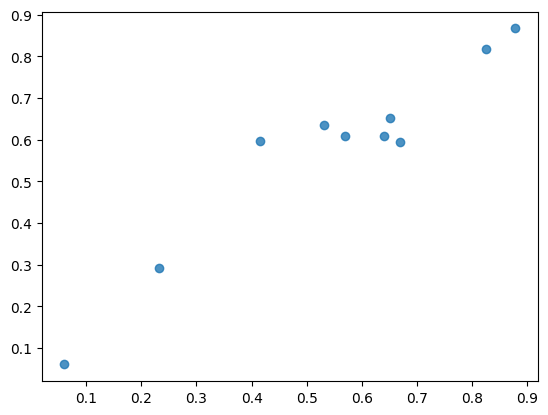

In [110]:
plt.scatter(parameter_recovery_df['fitted_alpha'], parameter_recovery_df['simulated_alpha'], marker = 'o', alpha = 0.8)
plt.xlabel("Simulate alpha")
plt.ylabel("Fitted alpha")

Text(0, 0.5, 'Fitted beta')

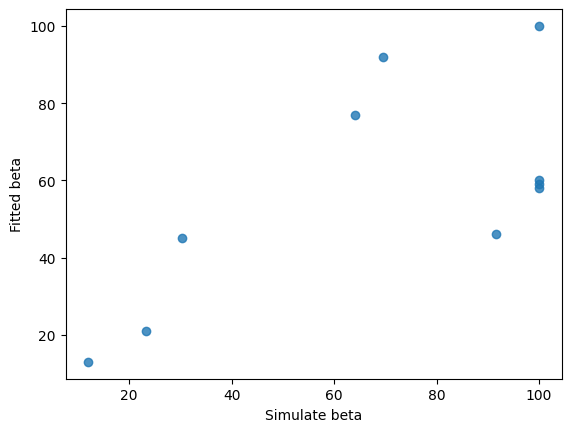

In [115]:
plt.scatter(parameter_recovery_df['fitted_beta'], parameter_recovery_df['simulated_beta'], marker = 'o', alpha = 0.8)
plt.xlabel("Simulate beta")
plt.ylabel("Fitted beta")

YAY! We are finished with parameter recovery. 

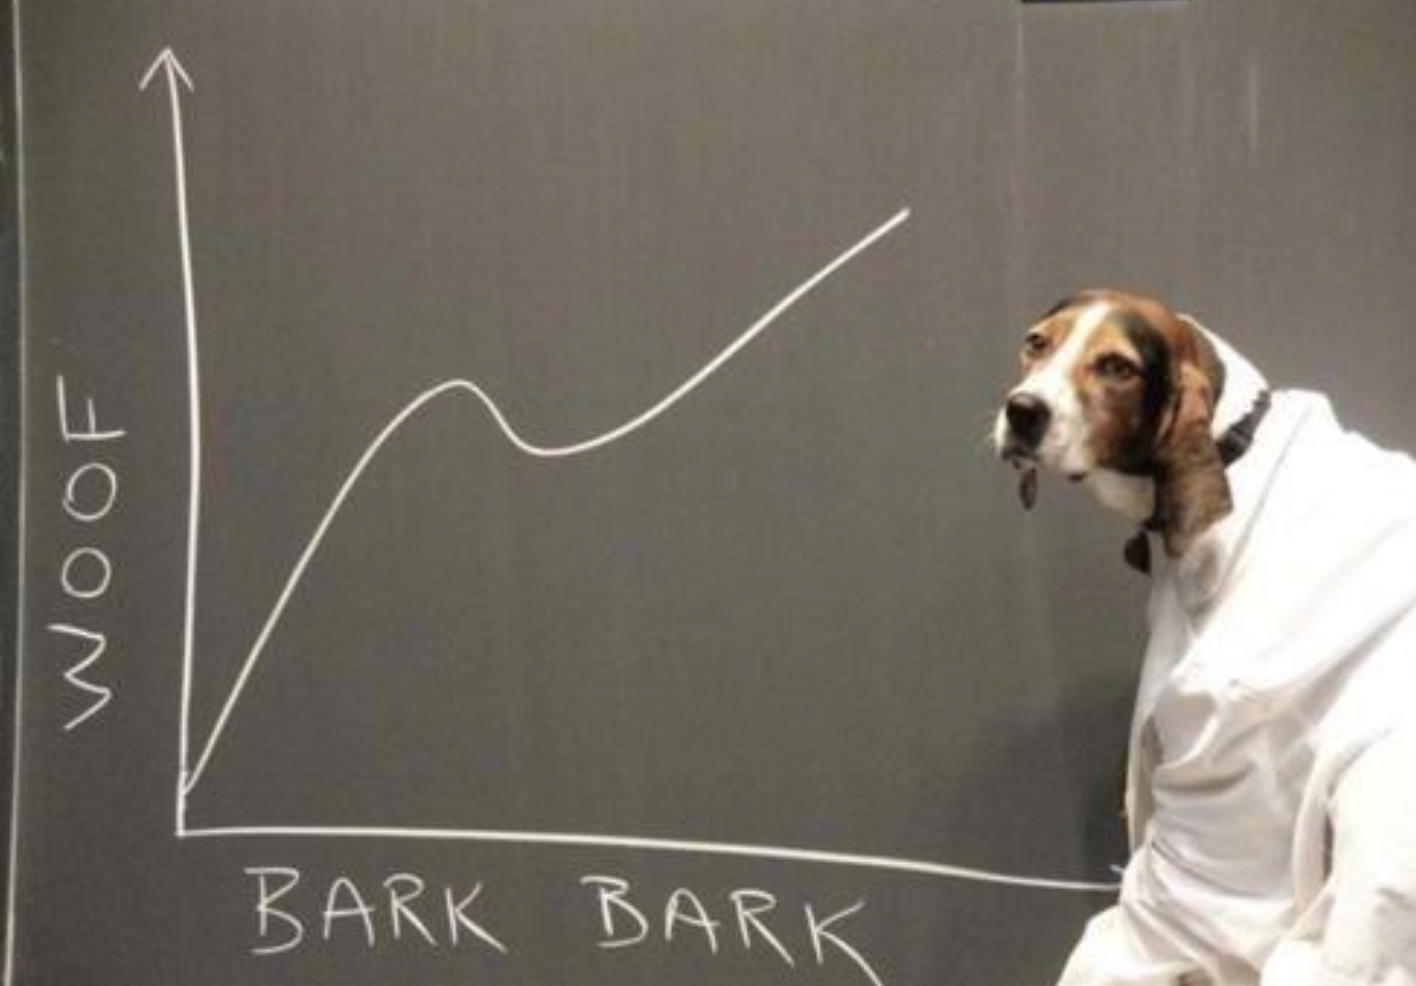

<font size= 4> **Model Recovery** 

Let's simulate multiple reptitions of each model and then fit data simulated with a particular model with itself and competiting models. A BIC score will be computed for each model fit. The BIC resulting from a given repetition's data being fit by the model that generated it *AND* the BIC resulting from a given repetition's data being fit by the competing model(s) will be compared. If model recovery is successful (i.e., the two models explain behavior that is dissociable from each other), the BIC should be *lower* when a given reptition's data is fit by the model that generated it. Lower BIC is indicative of better fit. BIC is derived from the log likelihood computed for a given repetition as follows:

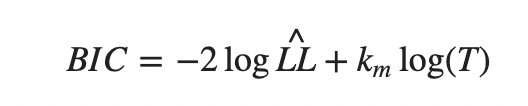

In [119]:
# Function to calculate the BIC of noisy win-stay-lose-shift model
def BIC_noisyWSLS(a, r):
    # a - a vector of length equal to the number of trials per rep containing choice history for a given repetition
    # r - a vector of length equal to the number of trials per rep containing reward history for a given repetition
    # epsilon - the value of epsilon used for simulation (passed here for visualizing parameter recovery)
    
    starting_epsilon = np.random.random()
    
    x0 = [starting_epsilon]
    
    bnds = ((0,1),) # sequence of min, max pairs for free parameters
    
    rep_data = pd.concat([a,r],axis=1) # pass these values as a data frame
    
    optim_output = minimize(negLL_noisyWSLS, x0, args=(rep_data),method='L-BFGS-B',bounds=bnds)
    neg_loglikelihood = optim_output.fun
    
    BIC = len(x0) * np.log(len(a)) + 2*neg_loglikelihood 
    return BIC

In [120]:
# Function to calculate the BIC of Rescola Wagner model
def BIC_rescola_wagner(a, r):
    # a - a vector of length equal to the number of trials per rep containing choice history for a given repetition
    # r - a vector of length equal to the number of trials per rep containing reward history for a given repetition
    # alpha - the value of alpha used for simulation (passed here for visualizing parameter recovery)
    # beta - the value of beta used for simulation (passed here for visualizing parameter recovery)
    
    starting_alpha = np.random.random()
    starting_beta = random.randint(1,100)
    
    x0 = [starting_alpha,starting_beta]
    
    bnds = ((0, 1), (1, 100)) # sequence of min, max pairs for alpha and beta
    
    rep_data = pd.concat([a,r],axis=1) # pass these values as a data frame
    
    optim_output = minimize(negLL_rescola_wagner, x0, args=(rep_data),method='L-BFGS-B',bounds=bnds)
    neg_loglikelihood = optim_output.fun
    
    BIC = len(x0) * np.log(len(a)) + 2*neg_loglikelihood
    return BIC

In [121]:
# Perform model fitting over 100 repetitions of each model and visualize the results using a confusion matrix
# initialize CM based on the number of models we are recovering (in this case it is two: noisy WSLS, and RW)
confusion_matrix = np.matrix('0 0; 0 0')

# noisy WSLS
n_reps = 100

for r in range(n_reps):
    epsilon_test = np.random.random()
    noisy_WSLS_rep_results = noisy_WSLS(T=number_of_trials, mu=[0.2, 0.8], epsilon = epsilon_test, rep = current_rep)
    
    choice = noisy_WSLS_rep_results["choice"]
    reward = noisy_WSLS_rep_results["reward"]
    
    noisyWSLS_BIC = BIC_noisyWSLS(a= choice, r= reward)
    RW_BIC = BIC_rescola_wagner(a= choice, r= reward)
    bic_values = [noisyWSLS_BIC,RW_BIC] # noisy WSLS, RW
    min_bic_value = min(bic_values)
    lowest_bic_index = np.where(bic_values == min_bic_value)[0][0]
    
# update confusion matrix with noisy WSLS fitting result
confusion_matrix[0,lowest_bic_index] = confusion_matrix[0,lowest_bic_index] + 1

for r in range(n_reps):
    alpha_test = np.random.random()
    beta_test = random.randint(1,100)
    RW_rep_results = rescola_wagner(T=number_of_trials, mu=[0.2, 0.8], alpha = alpha_test, beta = beta_test, rep = current_rep)

    choice = RW_rep_results["choice"]
    reward = RW_rep_results["reward"]
    
    noisyWSLS_BIC = BIC_noisyWSLS(a= choice, r= reward)
    RW_BIC = BIC_rescola_wagner(a= choice, r= reward)
    bic_values = [noisyWSLS_BIC,RW_BIC] # noisy WSLS, RW
    min_bic_value = min(bic_values)
    lowest_bic_index = np.where(bic_values == min_bic_value)[0][0]

# update confusion matrix with RW fitting result
confusion_matrix[1,lowest_bic_index] = confusion_matrix[1,lowest_bic_index] + 1

In [122]:
confusion_matrix

matrix([[1, 0],
        [0, 1]])

Text(50.72222222222221, 0.5, 'Fitted')

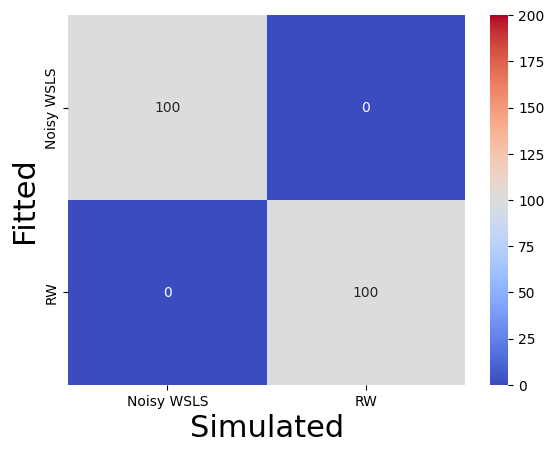

In [124]:
# Visualize the confusion matrix 
#Create pandas dataframe with confusion matrix
lang = ['Noisy WSLS', 'RW']
confusion_matrix = confusion_matrix * 100
conf_matrix_df = pd.DataFrame(confusion_matrix,columns=lang,index=lang)

#Plot confusion matrix heatmap
sns.heatmap(conf_matrix_df,cmap='coolwarm',annot=True,fmt='.5g',vmax=200)

plt.xlabel('Simulated',fontsize=22)
plt.ylabel('Fitted',fontsize=22)

Nice job!!! You've successful performed the following steps for computational modeling of behavior: 1. **simulation**, 2. **parameter recovery**, 3. **model recovery**

The next step would be to collect data from real-life participants completing your bandit task and try fitting your models to their behavioral data. This will allow you to see which model best explains their behavior (**model comparison**) and check for individual differences in participants' fitted parameter values (**parameter fitting**) - super cool!

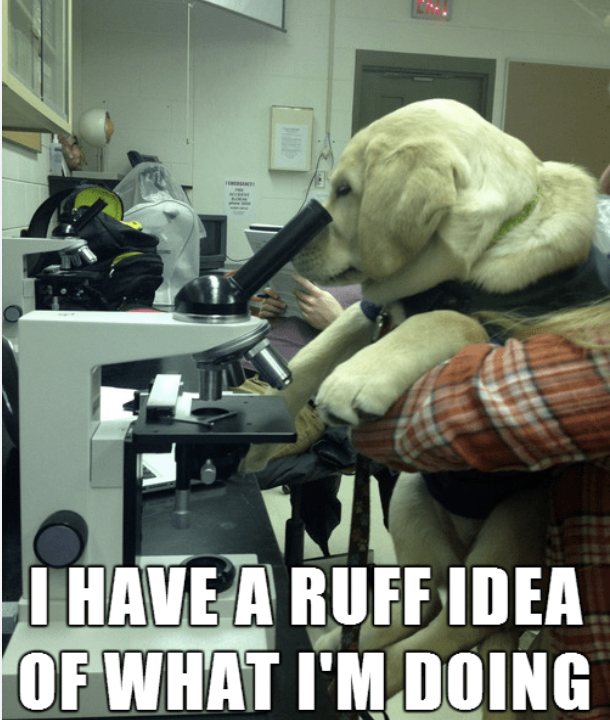